In [ ]:
# !apt-get --purge remove cuda nvidia* libnvidia-*
# !dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
# !apt-get remove cuda-*
# !apt autoremove
# !apt-get update
# !wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
# !apt-get update
# !apt-get install cuda-9.2
# !pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
# %load_ext nvcc_plugin

In [ ]:
# Install libAUC and medMNIST
!pip install libauc==1.2.0
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116952 sha256=e6635c9bbcf372dcb0682f808da8ea385908d39e46082d6cb10a59a7ca67d7cd
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator

In [ ]:
## loading PneumoniaMNIST dataset

#data_flag = 'pathmnist'
data_flag = 'breastmnist'
download = True

#NUM_EPOCHS = 3
BATCH_SIZE = 64
#lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# transformer definitions -- go here
# default transformer


## transfomer to experiment --  
# the below is data --augmentation -- transformer
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# load the data
train_dataset = DataClass(split='train', transform=transform_train, download=download)
test_dataset = DataClass(split='test', transform=transform_train, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)



100%|██████████| 559580/559580 [00:00<00:00, 572835.66it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 156
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1'

In [ ]:
from torchvision.models import Weights
# instantiate the ResNet-50 model and set it to training mode
# model = ResNet50() --> yielded  low AUC and ACC on train and test data.
# instantiate the ResNet-18 model[Single Channel] and set it to training mode --
# added dropout and batch normalization as regularization methods.
import torchvision
model = torchvision.models.resnet18()
# model = model.cuda()
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)



from libauc.losses import AUCMLoss
from libauc.optimizers import PESG

SEED = 123
BATCH_SIZE = 128
imratio = 0.1 # for demo 
total_epochs = 100
decay_epochs = [50, 75]

# Set new hyperparameters
lr = 0.1  # Lower learning rate
weight_decay = 0.01  # Decrease weight decay
margin = 1.0
loss_fn = AUCMLoss()

# Set optimizer with new hyperparameters
optimizer = PESG(model, 
                 loss_fn=loss_fn, 
                 momentum=0.8,
                 margin=margin,
                 epoch_deacy = 0.03,
                 lr=lr)


In [ ]:
# lib AUC implementation
# modified the criteria for the 
from sklearn.metrics import roc_auc_score

from libauc.sampler import DualSampler
from libauc.metrics import auc_roc_score



print ('Start Training')
print ('-'*30)

train_log = []
test_log = []
for epoch in range(total_epochs):
  
     train_loss = []
     model.train()    
     for data, targets in tqdm(train_loader):
         y_pred = model(data)
         loss = loss_fn(y_pred, targets)
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()
         train_loss.append(loss.item())
     
     # evaluation on train & test sets
     model.eval()
     train_pred_list = []
     train_true_list = []
     for train_data, train_targets in train_loader_at_eval:
         train_pred = model(train_data)
         train_pred_list.append(train_pred.cpu().detach().numpy())
         train_true_list.append(train_targets.numpy())
     train_true = np.concatenate(train_true_list)
     train_pred = np.concatenate(train_pred_list)
     train_auc = auc_roc_score(train_true, train_pred)
     train_loss = np.mean(train_loss)
  
     test_pred_list = []
     test_true_list = [] 
     for test_data, test_targets in test_loader:
         test_pred = model(test_data)
         test_pred_list.append(test_pred.cpu().detach().numpy())
         test_true_list.append(test_targets.numpy())
     test_true = np.concatenate(test_true_list)
     test_pred = np.concatenate(test_pred_list)
     test_auc =  auc_roc_score(test_true, test_pred) 
     model.train()
 
     # print results
     print("epoch: %s, train_loss: %.4f, train_auc: %.4f, test_auc: %.4f, lr: %.4f"%(epoch, train_loss, train_auc[0], test_auc[0], optimizer.lr ))    
     train_log.append(train_auc[0]) 
     test_log.append(val_auc[0])

     

Start Training
------------------------------


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


epoch: 0, train_loss: 23.3919, train_auc: 0.5267, test_auc: 0.5401, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


epoch: 1, train_loss: 6.4447, train_auc: 0.6346, test_auc: 0.6280, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


epoch: 2, train_loss: 0.2380, train_auc: 0.5206, test_auc: 0.4891, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


epoch: 3, train_loss: 0.9706, train_auc: 0.7426, test_auc: 0.6959, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


epoch: 4, train_loss: 0.2594, train_auc: 0.7447, test_auc: 0.7197, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


epoch: 5, train_loss: 0.1720, train_auc: 0.7630, test_auc: 0.7168, lr: 0.1000


100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


epoch: 6, train_loss: 0.1473, train_auc: 0.7806, test_auc: 0.7448, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


epoch: 7, train_loss: 0.2685, train_auc: 0.7861, test_auc: 0.7523, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


epoch: 8, train_loss: 0.1211, train_auc: 0.7947, test_auc: 0.7611, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


epoch: 9, train_loss: 0.2238, train_auc: 0.7458, test_auc: 0.7153, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


epoch: 10, train_loss: 0.1452, train_auc: 0.8120, test_auc: 0.7703, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


epoch: 11, train_loss: 0.1477, train_auc: 0.7822, test_auc: 0.7477, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


epoch: 12, train_loss: 0.1144, train_auc: 0.8304, test_auc: 0.7763, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


epoch: 13, train_loss: 0.1197, train_auc: 0.8371, test_auc: 0.7918, lr: 0.1000


100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


epoch: 14, train_loss: 0.0997, train_auc: 0.8529, test_auc: 0.7953, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


epoch: 15, train_loss: 0.1039, train_auc: 0.8633, test_auc: 0.8010, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


epoch: 16, train_loss: 0.2420, train_auc: 0.8686, test_auc: 0.8074, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


epoch: 17, train_loss: 0.2291, train_auc: 0.8775, test_auc: 0.8156, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


epoch: 18, train_loss: 0.0973, train_auc: 0.8854, test_auc: 0.8254, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


epoch: 19, train_loss: 0.1199, train_auc: 0.8895, test_auc: 0.8277, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


epoch: 20, train_loss: 0.1316, train_auc: 0.8961, test_auc: 0.8423, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


epoch: 21, train_loss: 0.0796, train_auc: 0.8962, test_auc: 0.8465, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


epoch: 22, train_loss: 0.1001, train_auc: 0.9272, test_auc: 0.8509, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


epoch: 23, train_loss: 0.0768, train_auc: 0.9166, test_auc: 0.8375, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


epoch: 24, train_loss: 0.0958, train_auc: 0.9204, test_auc: 0.8561, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


epoch: 25, train_loss: 0.1310, train_auc: 0.9335, test_auc: 0.8642, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


epoch: 26, train_loss: 0.0703, train_auc: 0.9461, test_auc: 0.8647, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


epoch: 27, train_loss: 0.0719, train_auc: 0.9472, test_auc: 0.8791, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


epoch: 28, train_loss: 0.0738, train_auc: 0.9579, test_auc: 0.8893, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


epoch: 29, train_loss: 0.0594, train_auc: 0.8581, test_auc: 0.7993, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


epoch: 30, train_loss: 0.0734, train_auc: 0.9541, test_auc: 0.8803, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


epoch: 31, train_loss: 0.0513, train_auc: 0.9681, test_auc: 0.8795, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


epoch: 32, train_loss: 0.0646, train_auc: 0.9671, test_auc: 0.8709, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


epoch: 33, train_loss: 0.1865, train_auc: 0.9746, test_auc: 0.8904, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


epoch: 34, train_loss: 0.0502, train_auc: 0.9738, test_auc: 0.8816, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


epoch: 35, train_loss: 0.0381, train_auc: 0.9819, test_auc: 0.8855, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


epoch: 36, train_loss: 0.1660, train_auc: 0.9598, test_auc: 0.8578, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


epoch: 37, train_loss: 0.0946, train_auc: 0.9836, test_auc: 0.9075, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


epoch: 38, train_loss: 0.0390, train_auc: 0.9850, test_auc: 0.9112, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


epoch: 39, train_loss: 0.0823, train_auc: 0.9805, test_auc: 0.8904, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


epoch: 40, train_loss: 0.0645, train_auc: 0.9918, test_auc: 0.9162, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


epoch: 41, train_loss: 0.0342, train_auc: 0.9775, test_auc: 0.8887, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


epoch: 42, train_loss: 0.0437, train_auc: 0.9905, test_auc: 0.9127, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


epoch: 43, train_loss: 0.0250, train_auc: 0.9893, test_auc: 0.8958, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


epoch: 44, train_loss: 0.0277, train_auc: 0.9927, test_auc: 0.8989, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


epoch: 45, train_loss: 0.0958, train_auc: 0.9897, test_auc: 0.9033, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


epoch: 46, train_loss: 0.0277, train_auc: 0.9960, test_auc: 0.9160, lr: 0.1000


100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


epoch: 47, train_loss: 0.0185, train_auc: 0.9934, test_auc: 0.9023, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


epoch: 48, train_loss: 0.0187, train_auc: 0.9574, test_auc: 0.8452, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


epoch: 49, train_loss: 0.0322, train_auc: 0.9967, test_auc: 0.8939, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


epoch: 50, train_loss: 0.0229, train_auc: 0.9973, test_auc: 0.9110, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


epoch: 51, train_loss: 0.0189, train_auc: 0.9902, test_auc: 0.8929, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


epoch: 52, train_loss: 0.0249, train_auc: 0.9936, test_auc: 0.9200, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


epoch: 53, train_loss: 0.0253, train_auc: 0.9957, test_auc: 0.8991, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


epoch: 54, train_loss: 0.0322, train_auc: 0.9886, test_auc: 0.8789, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


epoch: 55, train_loss: 0.0204, train_auc: 0.9995, test_auc: 0.9098, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


epoch: 56, train_loss: 0.0253, train_auc: 0.9995, test_auc: 0.9165, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


epoch: 57, train_loss: 0.0160, train_auc: 0.9981, test_auc: 0.8897, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


epoch: 58, train_loss: 0.0159, train_auc: 0.9961, test_auc: 0.9085, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


epoch: 59, train_loss: 0.0227, train_auc: 0.9994, test_auc: 0.9035, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


epoch: 60, train_loss: 0.0148, train_auc: 0.9998, test_auc: 0.9002, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


epoch: 61, train_loss: 0.0431, train_auc: 0.9935, test_auc: 0.8979, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


epoch: 62, train_loss: 0.0150, train_auc: 0.9999, test_auc: 0.9066, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


epoch: 63, train_loss: 0.0186, train_auc: 0.9610, test_auc: 0.8945, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


epoch: 64, train_loss: 0.0150, train_auc: 0.9999, test_auc: 0.9104, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


epoch: 65, train_loss: 0.0097, train_auc: 0.9999, test_auc: 0.9112, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


epoch: 66, train_loss: 0.0121, train_auc: 0.9838, test_auc: 0.8709, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


epoch: 67, train_loss: 0.0202, train_auc: 0.9997, test_auc: 0.9041, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


epoch: 68, train_loss: 0.0101, train_auc: 0.9999, test_auc: 0.8970, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


epoch: 69, train_loss: 0.0098, train_auc: 0.9981, test_auc: 0.8876, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


epoch: 70, train_loss: 0.0096, train_auc: 0.9973, test_auc: 0.8947, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


epoch: 71, train_loss: 0.0122, train_auc: 1.0000, test_auc: 0.8954, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


epoch: 72, train_loss: 0.0122, train_auc: 0.9945, test_auc: 0.8964, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


epoch: 73, train_loss: 0.0160, train_auc: 1.0000, test_auc: 0.9179, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


epoch: 74, train_loss: 0.0237, train_auc: 0.9999, test_auc: 0.9016, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 75, train_loss: 0.0107, train_auc: 1.0000, test_auc: 0.9162, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


epoch: 76, train_loss: 0.0139, train_auc: 1.0000, test_auc: 0.9221, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


epoch: 77, train_loss: 0.0073, train_auc: 0.9999, test_auc: 0.9121, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


epoch: 78, train_loss: 0.0091, train_auc: 1.0000, test_auc: 0.9081, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


epoch: 79, train_loss: 0.0089, train_auc: 1.0000, test_auc: 0.9177, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


epoch: 80, train_loss: 0.0442, train_auc: 0.9998, test_auc: 0.9075, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


epoch: 81, train_loss: 0.0140, train_auc: 0.9960, test_auc: 0.8736, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


epoch: 82, train_loss: 0.0097, train_auc: 1.0000, test_auc: 0.9129, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


epoch: 83, train_loss: 0.0072, train_auc: 0.9999, test_auc: 0.9004, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


epoch: 84, train_loss: 0.0126, train_auc: 0.9995, test_auc: 0.9121, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


epoch: 85, train_loss: 0.0095, train_auc: 0.9959, test_auc: 0.9087, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


epoch: 86, train_loss: 0.0069, train_auc: 0.9738, test_auc: 0.8536, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.07it/s]


epoch: 87, train_loss: 0.0090, train_auc: 1.0000, test_auc: 0.9194, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


epoch: 88, train_loss: 0.0108, train_auc: 1.0000, test_auc: 0.9098, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


epoch: 89, train_loss: 0.0088, train_auc: 0.9998, test_auc: 0.9087, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


epoch: 90, train_loss: 0.0089, train_auc: 1.0000, test_auc: 0.9041, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


epoch: 91, train_loss: 0.0056, train_auc: 1.0000, test_auc: 0.9156, lr: 0.1000


100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


epoch: 92, train_loss: 0.0107, train_auc: 1.0000, test_auc: 0.9221, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


epoch: 93, train_loss: 0.0073, train_auc: 1.0000, test_auc: 0.8943, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.12it/s]


epoch: 94, train_loss: 0.0058, train_auc: 1.0000, test_auc: 0.8958, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


epoch: 95, train_loss: 0.0075, train_auc: 1.0000, test_auc: 0.9031, lr: 0.1000


100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


epoch: 96, train_loss: 0.0080, train_auc: 0.9999, test_auc: 0.9039, lr: 0.1000


100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


epoch: 97, train_loss: 0.0080, train_auc: 1.0000, test_auc: 0.9131, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


epoch: 98, train_loss: 0.0036, train_auc: 0.9859, test_auc: 0.8830, lr: 0.1000


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


epoch: 99, train_loss: 0.0054, train_auc: 1.0000, test_auc: 0.9098, lr: 0.1000


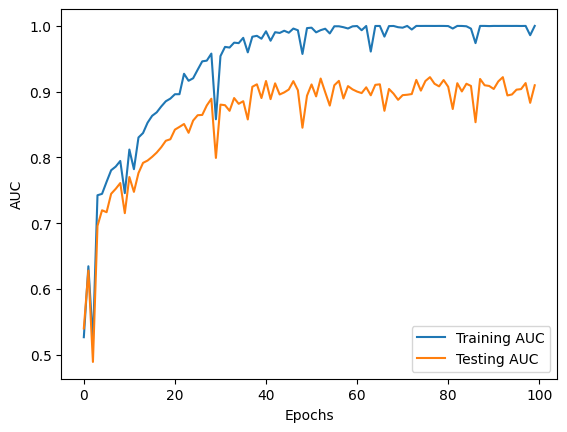

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_log, label='Training AUC')
plt.plot(test_log, label='Testing AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()


In [ ]:
print("Final Train AUC:", train_log[-1])
print("Final Test AUC:", test_log[-1])


Final Train AUC: 1.0
Final Test AUC: 0.9097744360902256
